In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize

In [4]:
data = pd \
    .read_csv('data/linear_regression.txt', names=['x', 'y']) \
    .sample(frac=1)
data.reset_index(inplace=True, drop=True)
data.head()

,x,y
0,5.0546,3.81660
1,7.0032,11.85400
2,5.1793,-0.74279
3,7.4239,4.28850
4,5.7107,3.25220


<AxesSubplot:xlabel='x', ylabel='y'>

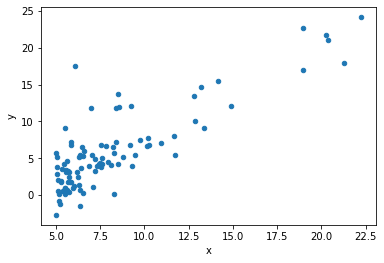

In [5]:
data.plot.scatter(x='x', y='y')

In [8]:
def extract(data, start, end):
    m = data.shape[0]
    view = data[start:(end - 1)]
    
    dropped_view = view
    if 'y' in data.columns:
        dropped_view = dropped_view.drop('y', axis=1)
    if 'y^' in data.columns:
        dropped_view = dropped_view.drop('y^', axis=1)
    X = dropped_view.to_numpy()
    y = view['y'].to_numpy().reshape(view.shape[0], 1)
    return X, y

def expand(data, p):
    p = p + 1
    m = data.shape[0]
    n = data.shape[1]
    result = data.copy()
    
    pv = [0] * n
    while True:
        r = 1
        sumof = 0
        for i in range(0, n):
            if data.columns[i] in ['y', 'y^']:
                continue
            pv[i] = pv[i] + r
            r = pv[i] // p
            pv[i] = pv[i] % p
            sumof = sumof + pv[i]
        if r > 0:
            break
        if sumof < 2:
            continue
        toadd = None
        name = ''
        for i in range(0, n):
            if pv[i] < 1 or data.columns[i] in ['y', 'y^']:
                continue
            name = name + data.columns[i]
            if pv[i] > 1:
                name = name + '^' + str(pv[i])
            temp = data[data.columns[i]].pow(pv[i])
            if toadd is None:
                toadd = temp
            else:
                toadd = toadd.add(temp)
        
        result[name] = toadd
        
    result.insert(0, 'x0', [1] * m)
        
    return result
    

def cost_fn(theta, X, y, lamb):
    # Note: np.multiply performs element-wise multiplication instead of matrix multiplication
    # Note: np.matmul performs matrix multiplication
    m = X.shape[0]
    n = X.shape[1]
    Theta = theta.reshape(n, 1)
    h = np.matmul(X, Theta)
    result = h - y
    result = np.sum(np.multiply(result, result)) / (2 * m)
    result = result + (lamb / (2 * m)) * (np.sum(np.multiply(Theta, Theta)) - math.pow(Theta[0,0], 2))
    
    return result

def gradient_fn(theta, X, y, lamb):
    m = X.shape[0]
    n = X.shape[1]
    Theta = theta.reshape(n, 1)
    h = np.matmul(X, Theta)
    result = (np.matmul(X.T, (h - y)) / m)
    
    lamb_vector = np.ones((n, 1))
    lamb_vector[0, 0] = 0
    
    result = result + (lamb / m) * np.multiply(lamb_vector, Theta)
    
    return result.reshape(n)

def solve(X, y, lamb):
    n = X.shape[1]
    result = optimize.minimize(
        lambda theta: cost_fn(theta, X, y, lamb),
        jac=lambda theta: gradient_fn(theta, X, y, lamb),
        x0=np.array([0] * n),
        method='BFGS')
    return result.x.reshape(n, 1)

def check_gradient_inner(n, cost_fn, gradient_fn):
    EPSILON = 1e-5
    theta = np.random.rand(n)
    result = np.zeros((n,))
    for i in range(0, n):
        theta[i] = theta[i] + EPSILON
        cost_plus = cost_fn(theta)
        theta[i] = theta[i] - 2 * EPSILON
        cost_minus = cost_fn(theta)
        theta[i] = theta[i] + EPSILON
        estimated_grad = (cost_plus - cost_minus) / (2 * EPSILON)
        real_grad = gradient_fn(theta)
        result[i] = (estimated_grad - real_grad[i]) / real_grad[i]
    return result

def check_gradient(data, lamb):
    m = data.shape[0]
    expanded = expand(data, 0)
    X, y = extract(expanded, 0, m + 1)
    n = X.shape[1]
    return check_gradient_inner(
        n,
        lambda theta: cost_fn(theta, X, y, lamb),
        lambda theta: gradient_fn(theta, X, y, lamb),
    )

def select_model(data, max_p):
    m = data.shape[0]

    df = pd.DataFrame(index=range(1, max_p + 1), columns=['power', 'cost'])
    for p in range(1, max_p + 1):
        expanded = expand(data, p)
        Xtrain, ytrain = extract(expanded, 0, math.ceil(m*0.8))
        Xcv, ycv = extract(expanded, math.ceil(m*0.8), m + 1)
        theta = solve(Xtrain, ytrain, 0)
        cost = cost_fn(theta, Xcv, ycv, 0)
        df.loc[p] = [p, cost]
        
    df.sort_values(by=['cost'], inplace=True)
    df.plot.line(x=0, y=1)
    
    return df
        

In [9]:
check_gradient(data, 0)

array([3.34744207e-11, 2.18490663e-12])

In [11]:
check_gradient(data, 10)

array([7.78547822e-11, 1.70484609e-12])

   power        cost
1      1    3.488935
2      2    3.490651
3      3    3.645388
4      4    5.924868
5      5     5.49659
6      6    4.718615
7      7    9.086389
8      8    4.244753
9      9    3.474454
10    10  189.522805


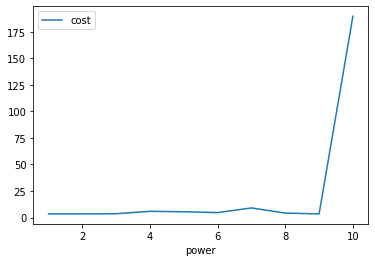

In [10]:
select_model(data, 10)

In [6]:
P = 4
expanded = expand(data, P)
X, y = extract(expanded, 0, data.shape[0] + 1)
Xtrain, ytrain = extract(expanded, 0, math.ceil(data.shape[0] * 0.8))
Xcv, ycv = extract(expanded, math.ceil(data.shape[0] * 0.8), data.shape[0] + 1)
theta = solve(X, y, 0)
del expanded
theta

In [7]:
def plot_model(data, P, theta, step):
    xmin = data['x'].min()
    xmax = data['x'].max()
    count = math.ceil((xmax - xmin) / step)
    Xplot = pd.DataFrame(index=range(0, count), columns=['x'])
    Xplot['x'] = np.arange(xmin, xmax, step)
    Xplot = expand(Xplot, P)
    Xplot['y'] = np.matmul(Xplot.to_numpy(), theta).reshape(Xplot.shape[0])

    ax = Xplot.plot.line(x='x', y='y',c='r')
    data.plot.scatter(x='x', y='y', c='b', ax=ax)

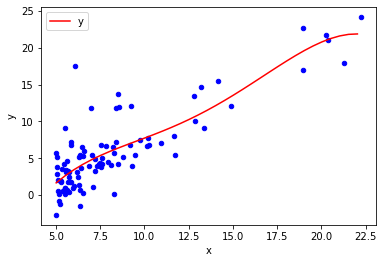

In [8]:
plot_model(data, P, theta, 0.5)

In [9]:
def select_lambda(Xtrain, ytrain, Xcv, ycv, begin, end, step):
    m = data.shape[0]
    
    count = math.ceil((end - begin) / step)
    df = pd.DataFrame(index=range(0, count), columns=['lambda', 'cost'])
    
    for i in range(0, count):
        lamb = begin + i * step
        theta = solve(Xtrain, ytrain, lamb)
        cost = cost_fn(theta, Xcv, ycv, 0)
        df.loc[i] = [lamb, cost]
        
    df.plot.line(x='lambda', y='cost')
    print(df)

    lambda      cost
0        1  3.834767
1        2  3.854181
2        3  3.861675
3        4  3.865663
4        5   3.86815
..     ...       ...
994    995  3.936762
995    996  3.936809
996    997  3.936857
997    998  3.936904
998    999  3.936951

[999 rows x 2 columns]


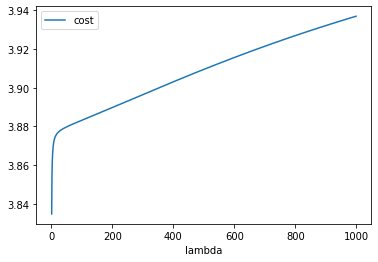

In [10]:
select_lambda(Xtrain, ytrain, Xcv, ycv, 0, 1000, 1)

In [11]:
lamb = 0
theta = solve(X, y, lamb)
data['y^'] = np.matmul(X, theta).reshape(X.shape[0])
theta

In [12]:
def draw_learning_curve(data, P, lamb, start=None, end=None):
    df = [] # m, cv, train
    expanded = expand(data, P)
    
    start = start or 0
    end = end or data.shape[0]
    
    for m in range(start, end + 1):  
        Xtrain, ytrain = extract(expanded, 0, math.ceil(m*0.8))
        Xcv, ycv = extract(expanded, math.ceil(m*0.8), m + 1)
        if ycv.shape[0] < 1:
            continue
        
        theta = solve(Xtrain, ytrain, lamb)
        cost_train = cost_fn(theta, Xtrain, ytrain, 0)
        cost_cv = cost_fn(theta, Xcv, ycv, 0)
        
        df.append([m, cost_cv, cost_train])
            
    df = pd.DataFrame(df, columns=['m', 'cv', 'train'])
    ax = df.plot.line(x='m', y='cv')
    df.plot.line(x='m', y='train', ax=ax)


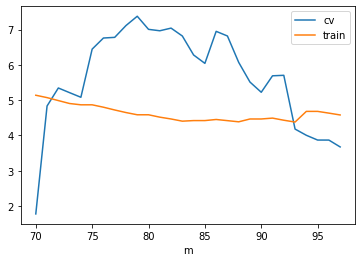

In [13]:
draw_learning_curve(data, P, lamb, start=70)

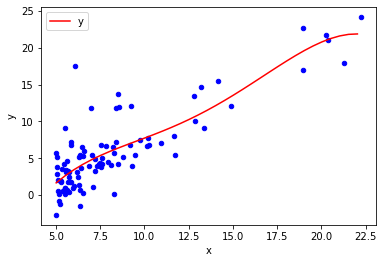

In [14]:
plot_model(data, P, theta, 0.5)